In [ ]:
# Cell 1: Imports

import numpy as np
import cv2
from skimage import filters, exposure, morphology, restoration
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt


# CoronarySAM v1.0 - Image Pre-Processing Pipeline

This notebook implements a comprehensive image pre-processing pipeline for coronary angiography images. The pipeline consists of three main stages:

1. Contrast Enhancement
2. Noise Reduction
3. Vessel Enhancement

Each stage is carefully designed to prepare angiography images for subsequent segmentation using the Segment Anything Model (SAM).

## Setup and Helper Functions
First, we'll define some helper functions to visualize our results throughout the pipeline.


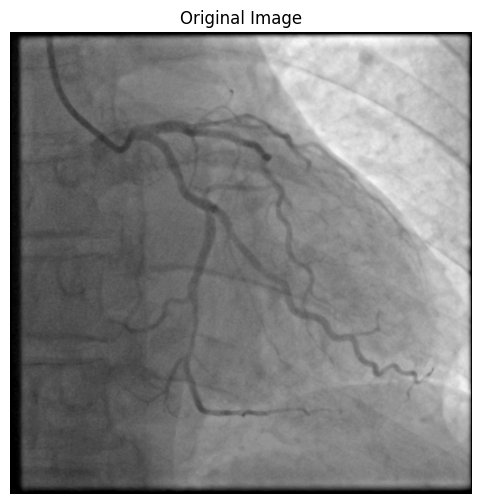

In [5]:
# Helper Functions 

def show_image_comparision(original, processed, titles = ['Original', 'Processed']):
    """Display Original and Processed images side by side"""
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(original, cmap='gray')
    plt.title(titles[0])
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(processed, cmap='gray')
    plt.title(titles[1])
    plt.axis('off')
    plt.show()    


    
def load_and_normalize(image_path):
    """Load and normalizr image to float32 [0,1] range """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img.astype(np.float32) / 255.0    

if __name__ == "__main__":
    img_path = "/Users/anand/STUDY/CASBLoDAM/141.png"
    img = load_and_normalize(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off') # no need of axis 
    plt.title('Original Image')
    plt.show()

## 0. Intensity Normalization

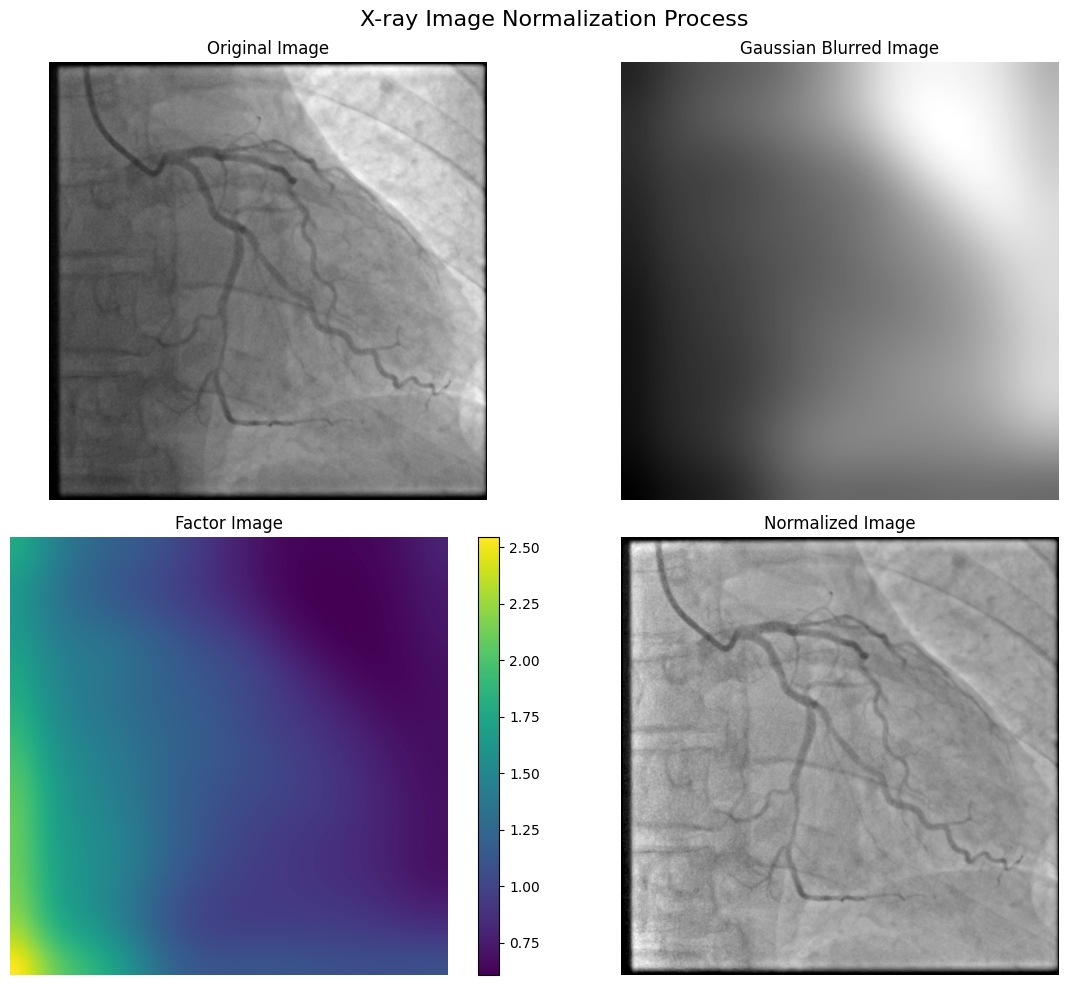

Mean intensity of blurred image: 122.37
Mean intensity of normalized image: 121.10
Average factor value: 1.11


In [6]:
def normalize_xray_image(image_path, kernel_size=(51,51), sigma=0):
    """
    Normalize X-ray image by applying Gaussian blur and intensity normalization.
    Returns intermediate results for visualization.
    
    Args:
        image_path (str): Path to the input image
        kernel_size (tuple): Size of Gaussian kernel (default: 5x5)
        sigma (float): Standard deviation for Gaussian kernel (default: 0)
        
    Returns:
        tuple: (original_image, blurred_image, factor_image, normalized_image)
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Could not read the image")
    
    # Convert to float for processing
    image = image.astype(float)
    
    # Step 1: Apply Gaussian blur for n iteration
    blurred = image.copy()
    for i in range(20):
        blurred = cv2.GaussianBlur(blurred, kernel_size, sigma)
    
    # Step 2: Calculate mean intensity of the blurred image
    mean_intensity = np.mean(blurred)
    
    # Step 3: Create factor image
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-10
    factor_image = mean_intensity / (blurred + epsilon)
    
    # Step 4: Multiply original image with factor image to get normalized result
    normalized_image = image * factor_image
    
    # Clip values to valid range
    normalized_image = np.clip(normalized_image, 0, 255)
    
    return image, blurred, factor_image, normalized_image

# Example usage
if __name__ == "__main__":
    
    # Get all intermediate images
    original, blurred, factor_image, normalized = normalize_xray_image(img_path)

    # Apply Gaussian blur and subtraction from blurred image
    # norm_k = cv2.GaussianBlur(normalized, (3,3), 0)
    # dest_img = normalized.copy()
    # cv2.subtract(norm_k, blurred, dest_img)
    
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('X-ray Image Normalization Process', fontsize=16)
    
    # Plot original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Plot blurred image
    axes[0, 1].imshow(blurred, cmap='gray')
    axes[0, 1].set_title('Gaussian Blurred Image')
    axes[0, 1].axis('off')
    
    # Plot factor image
    factor_plot = axes[1, 0].imshow(factor_image, cmap='viridis')
    axes[1, 0].set_title('Factor Image')
    axes[1, 0].axis('off')
    plt.colorbar(factor_plot, ax=axes[1, 0])
    
    # Plot normalized image
    axes[1, 1].imshow(normalized, cmap='gray')
    axes[1, 1].set_title('Normalized Image')
    axes[1, 1].axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Mean intensity of blurred image: {np.mean(blurred):.2f}")
    print(f"Mean intensity of normalized image: {np.mean(normalized):.2f}")
    print(f"Average factor value: {np.mean(factor_image):.2f}")

In [7]:
cv2.imwrite(img_path+"_norm", normalized)

True

## 1. Contrast Enhancement Functions:


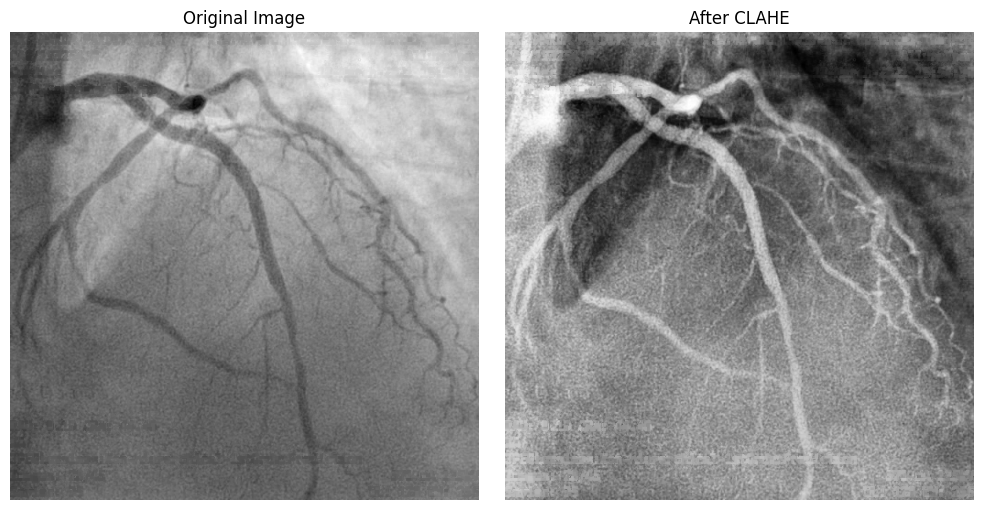

In [10]:
# Contrast Enhancement Functions

def apply_clahe(image, clip_limit=2.0, grid_size=(3,3)):
    """Apply CLAHE enhancement"""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

def gamma_correction(image, gamma=1.5):
    """Apply gamma correction"""
    return np.power(image, gamma)


# No need for Background subtraction as output is not that good
def background_subtraction(image, kernel_size=16):
    """Subtract background using morphological opening"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    background = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return np.clip(image - background, 0, 1)

def contrast_enhancement_pipeline(image):
    """Apply full contrast enhancement pipeline"""
    # CLAHE
    clahe_img = apply_clahe(image)
    
    # Gamma correction
    gamma_img = gamma_correction(clahe_img)
    
    # Background subtraction
    # enhanced_img = background_subtraction(gamma_img)
    enhanced_img = gamma_img
    
    return enhanced_img


# Detailed Test Version with Step-by-Step Visualization
if __name__ == "__main__":
    # Test image path
    image_path = "64 Images from doctor /Pre_processed_image/4.png"
    
    # Load image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Create figure for multiple comparisons
    plt.figure(figsize=(15, 10))
    
    # Original Image
    plt.subplot(231)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # CLAHE
    clahe_image = apply_clahe(original_image)
    plt.subplot(232)
    plt.imshow(clahe_image, cmap='gray')
    plt.title('After CLAHE')
    plt.axis('off')
    
    # # Gamma Correction
    # gamma_image = gamma_correction(clahe_image)
    # plt.subplot(233)
    # plt.imshow(gamma_image, cmap='gray')
    # plt.title('After Gamma Correction')
    # plt.axis('off')
    
    # # Background Subtraction
    # final_image = gamma_image
    # plt.subplot(234)
    # plt.imshow(final_image, cmap='gray')
    # plt.title('After Background Subtraction')
    # plt.axis('off')
    
    
    plt.tight_layout()
    plt.show()


## we will use only the normalization process for Image pre-processing pipeline